In [38]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances

In [39]:
import string
abcd = list(string.ascii_lowercase)

In [40]:
df_test = pd.read_csv('../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv',
                      index_col=0,parse_dates=True)
df_test = df_test['1948-01-01':'2023-12-31']

df_test.loc[df_test['corr']<=0.2,'WR']=np.unique(df_test['WR'])[-1]

# Read data

## b) frequency past and present

In [41]:
dic_labels = {}
names_reanalyses = ['ERA5','JRA3Q','NCEP_NCAR']
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [42]:
freqs_dic = {}
for reanalysis in names_reanalyses:
    df_temp = dic_labels[reanalysis]
    df_season = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
    freqs_past = 100*df_season['1948':'1977'].groupby('WR').count()['distances']/len(df_season['1948':'1977'])
    freqs_present = 100*df_season['1994':'2023'].groupby('WR').count()['distances']/len(df_season['1994':'2023'])
    freqs_dic[f'{reanalysis}_present'] = freqs_present
    freqs_dic[f'{reanalysis}_past'] = freqs_past

In [43]:
for reanalysis in names_reanalyses:
    df_temp = dic_labels[reanalysis]
    df_season = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
    df_season['year'] = df_season.index.year
    
    q05_past = []
    q95_past = []
    q05_present = []
    q95_present = []
    for wr in range(6):
        df_temp = df_season[df_season['WR']==wr]
        yearly_freq_past = 100*df_temp['1948':'1977'].groupby('year').count()['WR']/(365/2)
        bootstrapped_yearly_freqs = []
        for i in range(1000):
            np.random.seed(i)
            bootstrapped_yearly_freqs.append(np.random.choice(yearly_freq_past.values,size=len(yearly_freq_past)))
        
        q05_past.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.05,axis=0))
        q95_past.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.95,axis=0))
    
        df_temp = df_season[df_season['WR']==wr]
        yearly_freq_past = 100*df_temp['1994':'2023'].groupby('year').count()['WR']/(365/2)
        bootstrapped_yearly_freqs = []
        for i in range(1000):
            np.random.seed(i)
            bootstrapped_yearly_freqs.append(np.random.choice(yearly_freq_past.values,size=len(yearly_freq_past)))
        
        q05_present.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.05,axis=0))
        q95_present.append(np.quantile(np.mean(np.array(bootstrapped_yearly_freqs),axis=1),0.95,axis=0))
    
    freqs_dic[f'{reanalysis}_past_q05'] = np.array(q05_past)
    freqs_dic[f'{reanalysis}_past_q95'] = np.array(q95_past)
    freqs_dic[f'{reanalysis}_present_q05'] = np.array(q05_present)
    freqs_dic[f'{reanalysis}_present_q95'] = np.array(q95_present)

/glade/derecho/scratch/jhayron/tmp/ipykernel_72396/2384812260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['year'] = df_season.index.year
/glade/derecho/scratch/jhayron/tmp/ipykernel_72396/2384812260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['year'] = df_season.index.year
/glade/derecho/scratch/jhayron/tmp/ipykernel_72396/2384812260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [44]:
import string
abcd = list(string.ascii_lowercase)

In [45]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [46]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [47]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_72396/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_72396/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_72396/2337241071.py:16: FutureWarning: A value

In [48]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

In [49]:
wr=1

In [50]:
names_wrs = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

In [51]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

In [52]:
from scipy.stats import theilslopes
import statsmodels.api as sm

# a) compute difference in frequency and significance

In [53]:
reanalysis = 'ERA5'

In [54]:
# distribution freqpast shuffling labels for the season
diff_random_labels = []
for rs in range(1000):
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels = df_labels[(df_labels['season']=='Winter')|(df_labels['season']=='Spring')]
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(df_labels.values)), size=len(df_labels.values), replace=True)
    df_labels_random = df_labels.iloc[random_indices]
    df_labels_random.index = df_labels.index
    df_labels_random_past = df_labels_random.loc['1948':'1977']
    df_labels_random_future = df_labels_random.loc['1994':'2023']
    df_labels_random_past = df_labels_random_past[df_labels_random_past['WR']==wr]
    df_labels_random_future = df_labels_random_future[df_labels_random_future['WR']==wr]
    diff_random_labels.append(df_labels_random_future['WR'].count()/(30*365/2) - df_labels_random_past['WR'].count()/(30*365/2))
diff_random_labels = np.array(diff_random_labels)

# distribution freqpast shuffling years
diff_random_years_ind = []
for rs in range(1000):
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels_temp = df_labels[(df_labels['WR']==wr)&((df_labels['season']=='Spring')|(df_labels['season']=='Winter'))]
    yearly_freq = df_labels_temp.groupby(df_labels_temp.index.year).count()['WR']/(365/2)
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(yearly_freq.values)), size=len(yearly_freq.values), replace=True)
    yearly_freq_rand = yearly_freq.iloc[random_indices]
    yearly_freq_rand.index=yearly_freq.index
    diff_random_years_ind.append(yearly_freq_rand.loc['1948':'1977'].mean()\
                                 -yearly_freq_rand.loc['1994':'2023'].mean())

diff_random_years_ind = np.array(diff_random_years_ind)

In [55]:
diff_random_events = []
for rs in range(1000):
    np.random.seed(rs)
    df_temp = copy.deepcopy(dic_events[reanalysis])
    df_events = df_temp
    df_events = df_events[(df_events['season']=='Spring')|(df_events['season']=='Winter')]
    
    random_indices = np.random.choice(np.arange(len(df_temp.values)), size=len(df_temp.values), replace=True)
    df_events_random = pd.DataFrame(df_temp.values[random_indices],index=df_temp.index,columns=df_temp.keys())
    df_events_random = df_events_random[df_events_random['WR']==wr]
    
    dic_stats_temp = {}
    dic_stats_temp['n_days'] = []
    years = np.arange(start_year, end_year+1)
    for year in years:
        df_temp_temp = df_events_random.loc[str(year-N):str(year)]['duration']
        dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
    df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
    diff_random_events.append(df_stats_temp.values[1,0]-df_stats_temp.values[0,0])
diff_random_events = np.array(diff_random_events)

In [56]:
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])
df_events_temp = copy.deepcopy(dic_dfs_durations['ERA5'][f'wr{wr}'])
is_leap_year = df_events_temp.index.is_leap_year
total_days_in_year = np.where(is_leap_year, 366, 365)

# Convert DatetimeIndex to years in decimals
df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values

years = df_stats_temp.index
yearly_duration = df_events_temp.groupby('year')['duration'].mean()

diff_dur_random_years = []
for rs in range(1000):
    np.random.seed(rs)
    random_indices = np.random.choice(np.arange(len(yearly_duration)), size=len(yearly_duration), replace=True)
    yearly_dur_rand = yearly_duration.iloc[random_indices]
    yearly_dur_rand.index = yearly_duration.index
    diff_dur_random_years.append(yearly_dur_rand.loc['1994':'2023'].mean() - yearly_dur_rand.loc['1948':'1977'].mean())
diff_dur_random_years = np.array(diff_dur_random_years)

In [57]:
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])


In [58]:
df_stats_temp

,mean,std,p90,p10,p95,p05,n_events,n_days
1977,5.370079,3.318546,10.0,2.0,12.70,1.00,4.233333,0.124566
1978,5.404580,3.295168,10.0,2.0,12.50,1.00,4.366667,0.129315
1979,5.480916,3.374910,10.0,2.0,13.00,1.00,4.366667,0.131142
1980,5.578947,3.373719,10.0,2.0,13.00,1.00,4.433333,0.135525
1981,5.632353,3.411981,10.0,2.0,13.00,1.00,4.533333,0.139909
1982,5.686131,3.450814,10.4,2.0,13.00,1.00,4.566667,0.142283
1983,5.768116,3.521135,11.0,2.0,13.00,1.00,4.600000,0.145388
1984,5.851064,3.484529,11.0,2.0,13.00,1.00,4.700000,0.150685
1985,5.777778,3.497141,10.7,2.0,13.00,1.00,4.800000,0.151963
1986,5.972973,3.664401,11.0,2.0,13.65,1.00,4.933333,0.161461


In [59]:
diff_dur_random_yearly_blocks = []
diff_freq_random_yearly_blocks = []

for rs in range(1000):
    np.random.seed(rs)
    df_temp = copy.deepcopy(df_stats_temp)
    random_indices = np.random.choice(np.arange(len(df_temp)), size=len(df_temp), replace=True)
    random_diff_freq = df_temp.iloc[random_indices].n_days.values[-1] - df_temp.iloc[random_indices].n_days.values[0]
    random_diff_dur = df_temp.iloc[random_indices]['mean'].values[-1] - df_temp.iloc[random_indices]['mean'].values[0]

    diff_dur_random_yearly_blocks.append(random_diff_dur)
    diff_freq_random_yearly_blocks.append(random_diff_freq)

diff_dur_random_yearly_blocks = np.array(diff_dur_random_yearly_blocks)
diff_freq_random_yearly_blocks = np.array(diff_freq_random_yearly_blocks)

# Plots

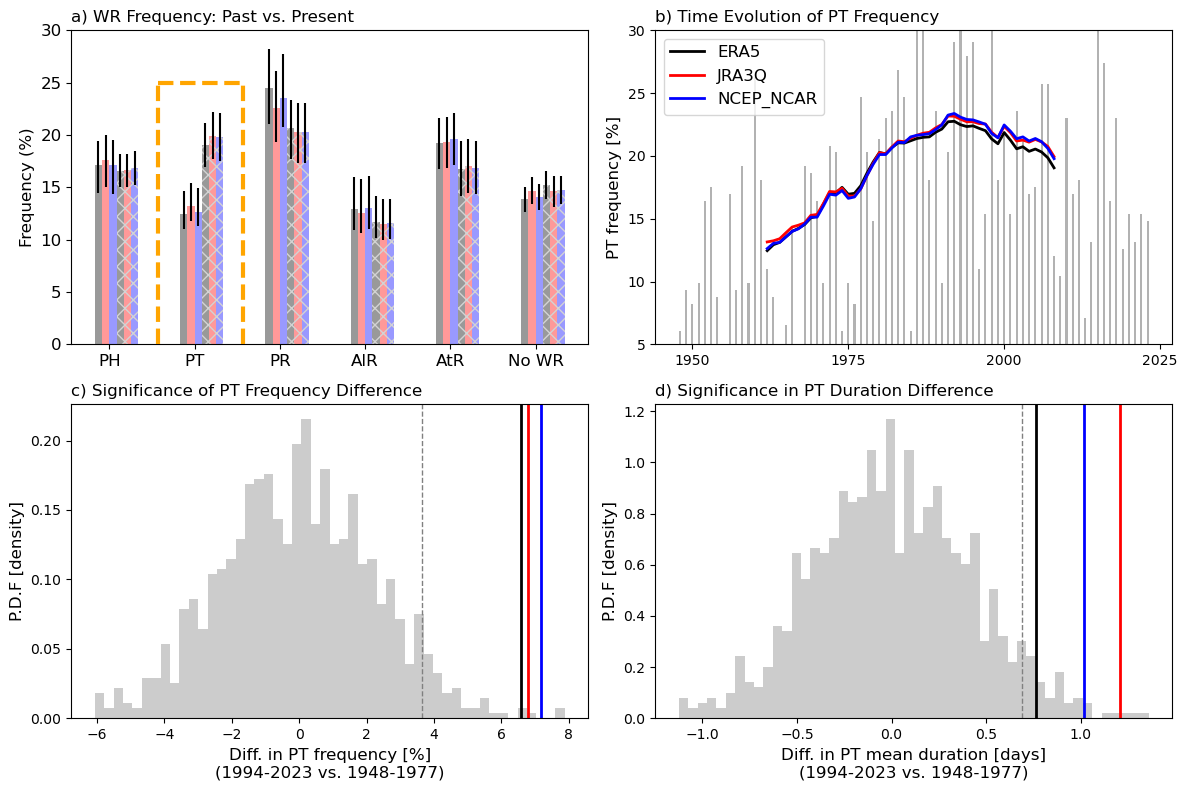

In [62]:
fontsize_most_things = 12
fontsize=fontsize_most_things

fig, axs = plt.subplots(
        2, 2,
        figsize=(12, 8))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

# ################# PLOT Frequency ######################
ax = axs_list[0]

colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

start_year_past='1948'
end_year_past='1977'
start_year_present='1994'
end_year_present='2023'
names_wrs = ["PH", "PT", "PR", "AlR", "AtR" ,"No WR"]
nwrs = 6
# colors_seasons = ['teal','limegreen','darkorange','darkorchid','k']
bar_width = 0.085  # Width of each bar
x = np.arange(nwrs)  # X positions for the groups
fontsize_bars = 8.5
dots_seasons_size = 40
color_lens2 = 'lightsteelblue'
color_era5 = 'lightgrey'
plt.rcParams['hatch.color'] = 'lightgray'

ir = 0
for reanalysis in names_reanalyses:

    overall_frequency = freqs_dic[f'{reanalysis}_past']
    percentiles_5 = freqs_dic[f'{reanalysis}_past_q05']
    percentiles_95 = freqs_dic[f'{reanalysis}_past_q95']
    # Plot bars for this reanalysis
    ax.bar(x + ir * bar_width, overall_frequency, 
           width=bar_width, color=colors_reanalyses[reanalysis],alpha=0.4,label=f'{reanalysis}: Past')
    ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5,zorder=11)
    ir+=1
    
for reanalysis in names_reanalyses:

    overall_frequency = freqs_dic[f'{reanalysis}_present']
    percentiles_5 = freqs_dic[f'{reanalysis}_present_q05']
    percentiles_95 = freqs_dic[f'{reanalysis}_present_q95']
    # Plot bars for this reanalysis
    ax.bar(x + ir * bar_width, overall_frequency, 
           width=bar_width, color=colors_reanalyses[reanalysis],alpha=0.4,hatch='xx',label=f'{reanalysis}: Present')
    ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5,zorder=11)
    ir+=1

ax.vlines(0.7, 0, 25, color='orange', lw=3,zorder=11,ls='--')
ax.vlines(1.7, 0, 25, color='orange', lw=3,zorder=11,ls='--')
ax.hlines(25, 0.7, 1.7, color='orange', lw=3,zorder=11,ls='--')


# Set x-ticks and labels
ax.set_xticks(x + bar_width * (len(names_reanalyses)) / 2)
ax.set_xticklabels(names_wrs, rotation=0, fontsize=fontsize_most_things)
# ax.set_yticks(np.arange(0, 36, 5))
ax.tick_params(axis='y', labelsize=fontsize_most_things)
ax.set_ylim(0, 30)
# # Add labels and title
# ax.set_xlabel('Weather Regimes', fontsize=fontsize_most_things)
ax.set_ylabel('Frequency (%)', fontsize=fontsize_most_things)
ax.set_title('a) WR Frequency: Past vs. Present',loc='left',fontsize=fontsize_most_things)
# Add this custom handle to the legend
# ax.legend(handles=ax.get_legend_handles_labels()[0], loc='best', fontsize=9,ncol=1)

#### Trend in frequency of the PT ####

ax = axs_list[1]
for reanalysis in names_reanalyses:
    ax.plot(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'].index-15,
            dic_stats_durations[reanalysis][f'wr{wr}']['n_days']*100,
            color=colors_reanalyses[reanalysis],label=reanalysis,lw=2)
    
# Plot metrics
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])
df_events_temp = copy.deepcopy(dic_dfs_durations['ERA5'][f'wr{wr}'])
is_leap_year = df_events_temp.index.is_leap_year
total_days_in_year = np.where(is_leap_year, 366, 365)

# Convert DatetimeIndex to years in decimals
df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values

years = df_stats_temp.index
yearly_count = df_events_temp.groupby('year').sum()['duration']

ax.bar(yearly_count.index,100*yearly_count/(365/2),color='k',alpha=0.3,width=0.33)
ax.set_ylim(5,30)
ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1950,2030,25))
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('b) Time Evolution of PT Frequency',loc='left',fontsize=fontsize)

#### Difference in frequency of the PT ####

ax = axs_list[2]
for reanalysis in names_reanalyses:
    diff = dic_stats_durations[reanalysis][f'wr{wr}']['n_days'].iloc[-1]-dic_stats_durations[reanalysis][f'wr{wr}']['n_days'].iloc[0]
    ax.axvline(diff*100,color=colors_reanalyses[reanalysis],label=reanalysis,lw=2)
ax.hist(diff_random_years_ind*100,color='gray',alpha=0.4,bins=50,density=True)
ax.axvline(np.percentile(diff_random_years_ind,95)*100,lw=1,ls='--',color='gray')
ax.set_xlabel('Diff. in PT frequency [%]\n(1994-2023 vs. 1948-1977)',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('c) Significance of PT Frequency Difference',loc='left',fontsize=fontsize)

#### Difference in duration of the PT ####

ax = axs_list[3]
for reanalysis in names_reanalyses:
    diff = dic_stats_durations[reanalysis][f'wr{wr}']['mean'].iloc[-1]-dic_stats_durations[reanalysis][f'wr{wr}']['mean'].iloc[0]
    ax.axvline(diff,color=colors_reanalyses[reanalysis],label=reanalysis,lw=2)
ax.hist(diff_dur_random_years,color='gray',alpha=0.4,bins=50,density=True)
ax.axvline(np.percentile(diff_dur_random_years,95),lw=1,ls='--',color='gray')
ax.set_xlabel('Diff. in PT mean duration [days]\n(1994-2023 vs. 1948-1977)',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('d) Significance in PT Duration Difference',loc='left',fontsize=fontsize)


plt.tight_layout()
plt.savefig('nFigures/2_PT_Changes.pdf',bbox_inches='tight')

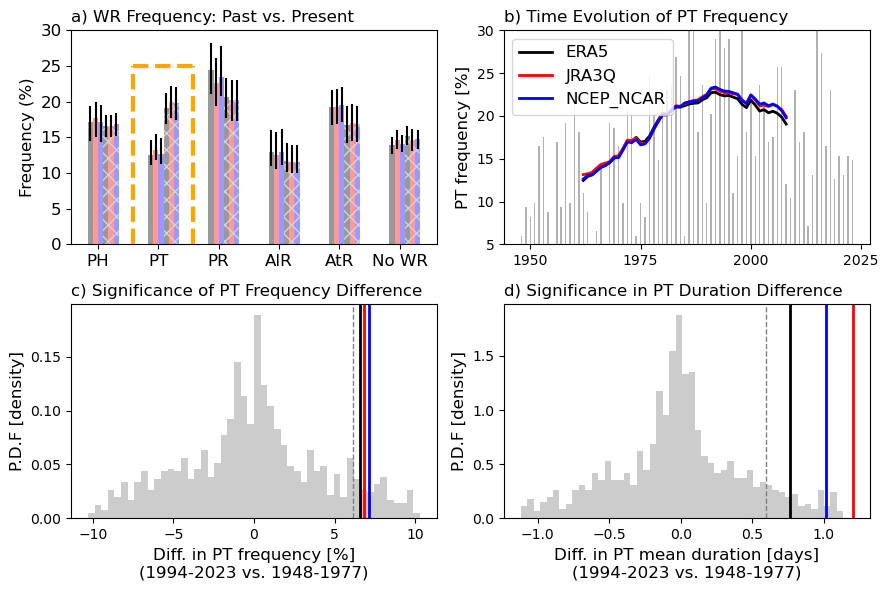

In [37]:
fontsize_most_things = 12
fontsize=fontsize_most_things

fig, axs = plt.subplots(
        2, 2,
        figsize=(9, 6))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]

# ################# PLOT Frequency ######################
ax = axs_list[0]

colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

start_year_past='1948'
end_year_past='1977'
start_year_present='1994'
end_year_present='2023'
names_wrs = ["PH", "PT", "PR", "AlR", "AtR" ,"No WR"]
nwrs = 6
# colors_seasons = ['teal','limegreen','darkorange','darkorchid','k']
bar_width = 0.085  # Width of each bar
x = np.arange(nwrs)  # X positions for the groups
fontsize_bars = 8.5
dots_seasons_size = 40
color_lens2 = 'lightsteelblue'
color_era5 = 'lightgrey'
plt.rcParams['hatch.color'] = 'lightgray'

ir = 0
for reanalysis in names_reanalyses:

    overall_frequency = freqs_dic[f'{reanalysis}_past']
    percentiles_5 = freqs_dic[f'{reanalysis}_past_q05']
    percentiles_95 = freqs_dic[f'{reanalysis}_past_q95']
    # Plot bars for this reanalysis
    ax.bar(x + ir * bar_width, overall_frequency, 
           width=bar_width, color=colors_reanalyses[reanalysis],alpha=0.4,label=f'{reanalysis}: Past')
    ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5,zorder=11)
    ir+=1
    
for reanalysis in names_reanalyses:

    overall_frequency = freqs_dic[f'{reanalysis}_present']
    percentiles_5 = freqs_dic[f'{reanalysis}_present_q05']
    percentiles_95 = freqs_dic[f'{reanalysis}_present_q95']
    # Plot bars for this reanalysis
    ax.bar(x + ir * bar_width, overall_frequency, 
           width=bar_width, color=colors_reanalyses[reanalysis],alpha=0.4,hatch='xx',label=f'{reanalysis}: Present')
    ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5,zorder=11)
    ir+=1

ax.vlines(0.7, 0, 25, color='orange', lw=3,zorder=11,ls='--')
ax.vlines(1.7, 0, 25, color='orange', lw=3,zorder=11,ls='--')
ax.hlines(25, 0.7, 1.7, color='orange', lw=3,zorder=11,ls='--')


# Set x-ticks and labels
ax.set_xticks(x + bar_width * (len(names_reanalyses)) / 2)
ax.set_xticklabels(names_wrs, rotation=0, fontsize=fontsize_most_things)
# ax.set_yticks(np.arange(0, 36, 5))
ax.tick_params(axis='y', labelsize=fontsize_most_things)
ax.set_ylim(0, 30)
# # Add labels and title
# ax.set_xlabel('Weather Regimes', fontsize=fontsize_most_things)
ax.set_ylabel('Frequency (%)', fontsize=fontsize_most_things)
ax.set_title('a) WR Frequency: Past vs. Present',loc='left',fontsize=fontsize_most_things)
# Add this custom handle to the legend
# ax.legend(handles=ax.get_legend_handles_labels()[0], loc='best', fontsize=9,ncol=1)

#### Trend in frequency of the PT ####

ax = axs_list[1]
for reanalysis in names_reanalyses:
    ax.plot(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'].index-15,
            dic_stats_durations[reanalysis][f'wr{wr}']['n_days']*100,
            color=colors_reanalyses[reanalysis],label=reanalysis,lw=2)
    
# Plot metrics
df_stats_temp = copy.deepcopy(dic_stats_durations['ERA5'][f'wr{wr}'])
df_events_temp = copy.deepcopy(dic_dfs_durations['ERA5'][f'wr{wr}'])
is_leap_year = df_events_temp.index.is_leap_year
total_days_in_year = np.where(is_leap_year, 366, 365)

# Convert DatetimeIndex to years in decimals
df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values

years = df_stats_temp.index
yearly_count = df_events_temp.groupby('year').sum()['duration']

ax.bar(yearly_count.index,100*yearly_count/(365/2),color='k',alpha=0.3,width=0.33)
ax.set_ylim(5,30)
ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1950,2030,25))
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('b) Time Evolution of PT Frequency',loc='left',fontsize=fontsize)

#### Difference in frequency of the PT ####

ax = axs_list[2]
for reanalysis in names_reanalyses:
    diff = dic_stats_durations[reanalysis][f'wr{wr}']['n_days'].iloc[-1]-dic_stats_durations[reanalysis][f'wr{wr}']['n_days'].iloc[0]
    ax.axvline(diff*100,color=colors_reanalyses[reanalysis],label=reanalysis,lw=2)
ax.hist(diff_freq_random_yearly_blocks*100,color='gray',alpha=0.4,bins=50,density=True)
ax.axvline(np.percentile(diff_freq_random_yearly_blocks,90)*100,lw=1,ls='--',color='gray')
ax.set_xlabel('Diff. in PT frequency [%]\n(1994-2023 vs. 1948-1977)',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('c) Significance of PT Frequency Difference',loc='left',fontsize=fontsize)

#### Difference in duration of the PT ####

ax = axs_list[3]
for reanalysis in names_reanalyses:
    diff = dic_stats_durations[reanalysis][f'wr{wr}']['mean'].iloc[-1]-dic_stats_durations[reanalysis][f'wr{wr}']['mean'].iloc[0]
    ax.axvline(diff,color=colors_reanalyses[reanalysis],label=reanalysis,lw=2)
ax.hist(diff_dur_random_yearly_blocks,color='gray',alpha=0.4,bins=50,density=True)
ax.axvline(np.percentile(diff_dur_random_yearly_blocks,90),lw=1,ls='--',color='gray')
ax.set_xlabel('Diff. in PT mean duration [days]\n(1994-2023 vs. 1948-1977)',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_title('d) Significance in PT Duration Difference',loc='left',fontsize=fontsize)


plt.tight_layout()
# plt.savefig('nFigures/2_PT_Changes.png',bbox_inches='tight')

/glade/derecho/scratch/jhayron/tmp/ipykernel_12313/782146463.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 4, 1, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_12313/782146463.py:118: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 4, 3, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_12313/782146463.py:156: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 4, 4, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_12313/782146463.py:194: MatplotlibDeprecationWarni

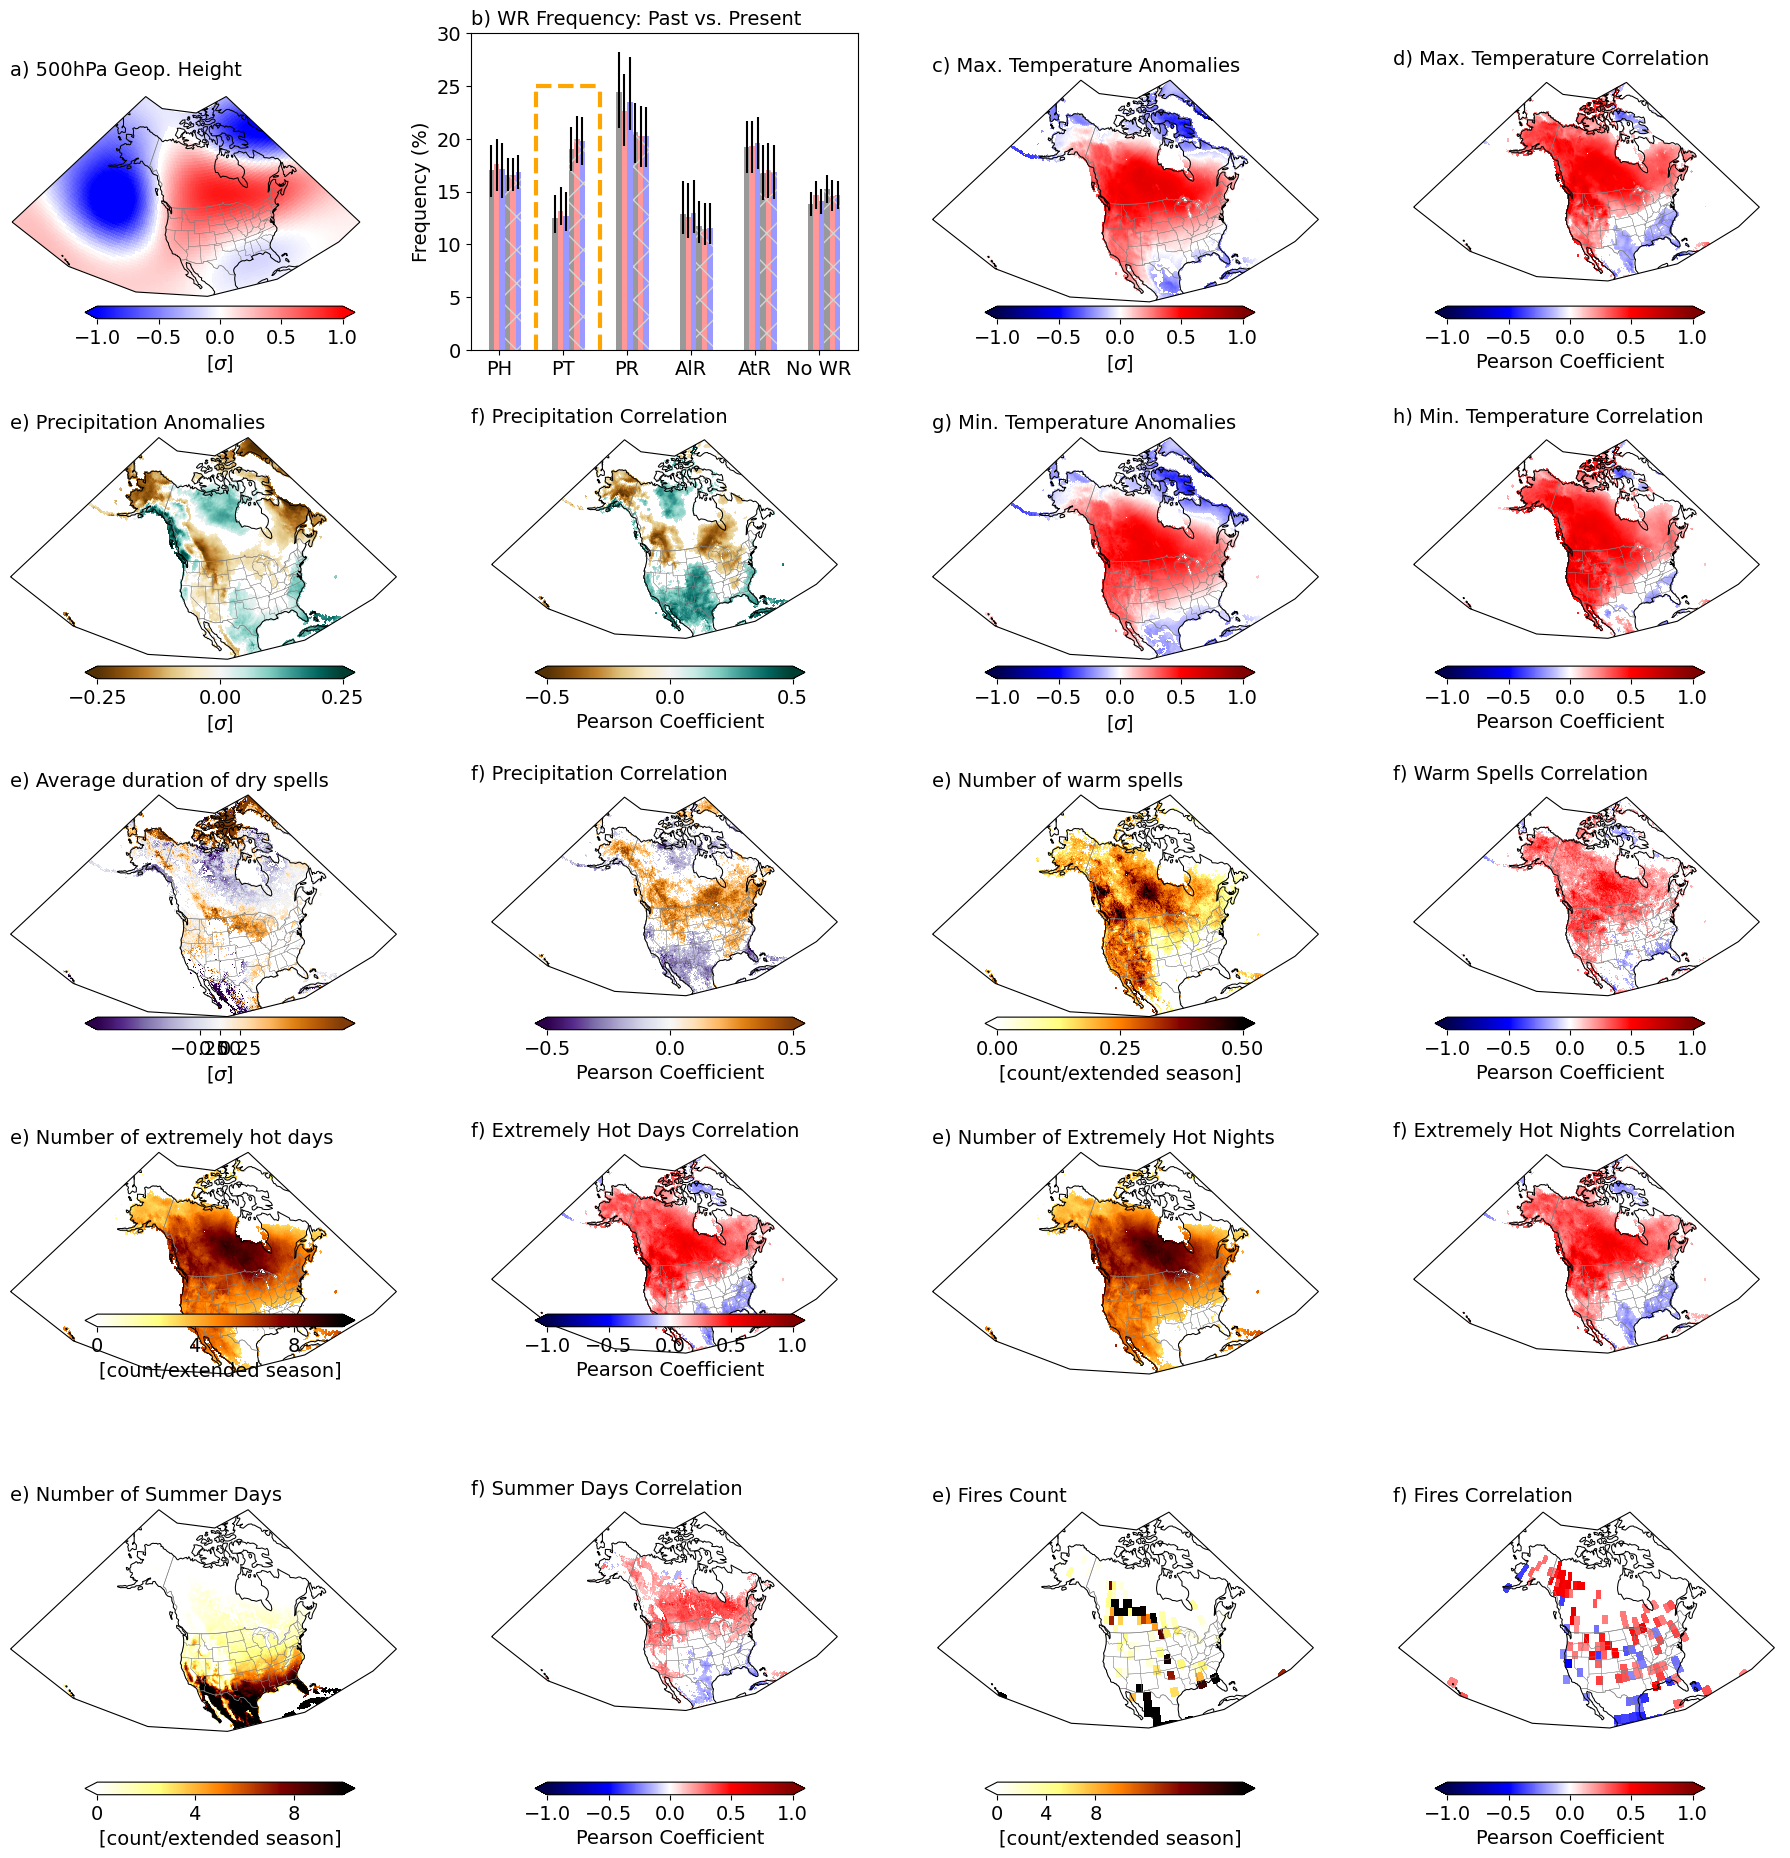

In [268]:
fontsize_most_things = 14

fig, axs = plt.subplots(
        5, 4,
        figsize=(18, 18))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]
# ################# PLOT Z500 ######################

ax = plt.subplot(5, 4, 1, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.
maxi=1.
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(z500_anoms.lon, 
        z500_anoms.lat, 
        z500_anoms.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='bwr')

ax.set_title(
    f'{abcd[0]}) 500hPa Geop. Height', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.05, 0.82, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Frequency ######################
ax = axs_list[1]

colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

start_year_past='1948'
end_year_past='1977'
start_year_present='1994'
end_year_present='2023'
names_wrs = ["PH", "PT", "PR", "AlR", "AtR" ,"No WR"]
nwrs = 6
# colors_seasons = ['teal','limegreen','darkorange','darkorchid','k']
bar_width = 0.085  # Width of each bar
x = np.arange(nwrs)  # X positions for the groups
fontsize_bars = 8.5
dots_seasons_size = 40
color_lens2 = 'lightsteelblue'
color_era5 = 'lightgrey'
plt.rcParams['hatch.color'] = 'lightgray'

ir = 0
for reanalysis in names_reanalyses:

    overall_frequency = freqs_dic[f'{reanalysis}_past']
    percentiles_5 = freqs_dic[f'{reanalysis}_past_q05']
    percentiles_95 = freqs_dic[f'{reanalysis}_past_q95']
    # Plot bars for this reanalysis
    ax.bar(x + ir * bar_width, overall_frequency, 
           width=bar_width, color=colors_reanalyses[reanalysis],alpha=0.4,label=f'{reanalysis}: Past')
    ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5,zorder=11)
    ir+=1
    
for reanalysis in names_reanalyses:

    overall_frequency = freqs_dic[f'{reanalysis}_present']
    percentiles_5 = freqs_dic[f'{reanalysis}_present_q05']
    percentiles_95 = freqs_dic[f'{reanalysis}_present_q95']
    # Plot bars for this reanalysis
    ax.bar(x + ir * bar_width, overall_frequency, 
           width=bar_width, color=colors_reanalyses[reanalysis],alpha=0.4,hatch='x',label=f'{reanalysis}: Present')
    ax.vlines(x + ir * bar_width, percentiles_5, percentiles_95, color='k', lw=1.5,zorder=11)
    ir+=1

ax.vlines(0.7, 0, 25, color='orange', lw=3,zorder=11,ls='--')
ax.vlines(1.7, 0, 25, color='orange', lw=3,zorder=11,ls='--')
ax.hlines(25, 0.7, 1.7, color='orange', lw=3,zorder=11,ls='--')


# Set x-ticks and labels
ax.set_xticks(x + bar_width * (len(names_reanalyses)) / 2)
ax.set_xticklabels(names_wrs, rotation=0, fontsize=fontsize_most_things)
# ax.set_yticks(np.arange(0, 36, 5))
ax.tick_params(axis='y', labelsize=fontsize_most_things)
ax.set_ylim(0, 30)
# # Add labels and title
# ax.set_xlabel('Weather Regimes', fontsize=fontsize_most_things)
ax.set_ylabel('Frequency (%)', fontsize=fontsize_most_things)
ax.set_title('b) WR Frequency: Past vs. Present',loc='left',fontsize=fontsize_most_things)
# Add this custom handle to the legend
# ax.legend(handles=ax.get_legend_handles_labels()[0], loc='best', fontsize=9,ncol=1)

# ################# PLOT Tmax anoms ######################

ax = plt.subplot(5, 4, 3, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.
maxi=1.
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tmax_anoms.lon, 
        tmax_anoms.lat, 
        tmax_anoms.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'c) Max. Temperature Anomalies', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.55, 0.82, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Tmax correlation ######################

ax = plt.subplot(5, 4, 4, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.
maxi=1.
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tmax_corr.lon, 
        tmax_corr.lat, 
        tmax_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'd) Max. Temperature Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.82, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT Tmin anoms ######################

ax = plt.subplot(5, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.
maxi=1.
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tmin_anoms.lon, 
        tmin_anoms.lat, 
        tmin_anoms.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'g) Min. Temperature Anomalies', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.55, 0.62, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Tmin correlation ######################

ax = plt.subplot(5, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.
maxi=1.
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tmin_corr.lon, 
        tmin_corr.lat, 
        tmin_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'h) Min. Temperature Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.62, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT Precip anoms ######################

ax = plt.subplot(5, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.25
maxi=0.25
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(precip_anoms.lon, 
        precip_anoms.lat, 
        precip_anoms.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'e) Precipitation Anomalies', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.05, 0.62, 0.15, 0.007])
ticks_1 = [-0.25, 0, 0.25]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT Precip correlation ######################

ax = plt.subplot(5, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(precip_corr.lon, 
        precip_corr.lat, 
        precip_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='BrBG')

ax.set_title(
    f'f) Precipitation Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.62, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT duration of dry spells composite ######################

ax = plt.subplot(5, 4, 9, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1.5
maxi=1.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(durdry_composite.lon, 
        durdry_composite.lat, 
        durdry_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='PuOr_r')

ax.set_title(
    f'e) Average duration of dry spells', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.05, 0.425, 0.15, 0.007])
ticks_1 = [-0.25,0,0.25]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$]', fontsize=fontsize_most_things)

# ################# PLOT duration of dry spells correlation ######################

ax = plt.subplot(5, 4, 10, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(durdry_corr.lon, 
        durdry_corr.lat, 
        durdry_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='PuOr_r')

ax.set_title(
    f'f) Precipitation Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.425, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT warm spells composite ######################

ax = plt.subplot(5, 4, 11, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_composite.lon, 
        ws_composite.lat, 
        ws_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='afmhot_r')

ax.set_title(
    f'e) Number of warm spells', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.55, 0.425, 0.15, 0.007])
ticks_1 = [0,0.25,0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/extended season]', fontsize=fontsize_most_things)

# ################# PLOT warm spells correlation ######################

ax = plt.subplot(5, 4, 12, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_corr.lon, 
        ws_corr.lat, 
        ws_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'f) Warm Spells Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.425, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT TX90 composite ######################

ax = plt.subplot(5, 4, 13, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=10
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_composite.lon, 
        tx90_composite.lat, 
        tx90_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='afmhot_r')

ax.set_title(
    f'e) Number of extremely hot days', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.05, 0.26, 0.15, 0.007])
ticks_1 = [0,4,8]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/extended season]', fontsize=fontsize_most_things)

# ################# PLOT TX90 correlation ######################

ax = plt.subplot(5, 4, 14, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_corr.lon, 
        tx90_corr.lat, 
        tx90_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'f) Extremely Hot Days Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.26, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# ################# PLOT TN90 composite ######################

ax = plt.subplot(5, 4, 15, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=10
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_composite.lon, 
        tx90_composite.lat, 
        tx90_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='afmhot_r')

ax.set_title(
    f'e) Number of Extremely Hot Nights', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.55, 0.225, 0.15, 0.007])
ticks_1 = [0,4,8]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/extended season]', fontsize=fontsize_most_things)

# ################# PLOT TN90 correlation ######################

ax = plt.subplot(5, 4, 16, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_corr.lon, 
        tx90_corr.lat, 
        tx90_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'f) Extremely Hot Nights Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.225, 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# # ################# PLOT TX25 composite ######################

ax = plt.subplot(5, 4, 17, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=10
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx25_composite.lon, 
        tx25_composite.lat, 
        tx25_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='afmhot_r')

ax.set_title(
    f'e) Number of Summer Days', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.05, 0., 0.15, 0.007])
ticks_1 = [0,4,8]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/extended season]', fontsize=fontsize_most_things)

# # ################# PLOT TX25 correlation ######################

ax = plt.subplot(5, 4, 18, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx25_corr.lon, 
        tx25_corr.lat, 
        tx25_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'f) Summer Days Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0., 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

# # ################# PLOT Fires composite ######################

ax = plt.subplot(5, 4, 19, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=20
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(fires_composite.lon, 
        fires_composite.lat, 
        fires_composite.composite,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='afmhot_r')

ax.set_title(
    f'e) Fires Count', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.55, 0., 0.15, 0.007])
ticks_1 = [0,4,8]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[count/extended season]', fontsize=fontsize_most_things)

# # ################# PLOT Fires correlation ######################

ax = plt.subplot(5, 4, 20, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-1
maxi=1
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(fires_corr.lon, 
        fires_corr.lat, 
        fires_corr.correlation,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='seismic')

ax.set_title(
    f'f) Fires Correlation', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0., 0.15, 0.007])
ticks_1 = [-1, -0.5, 0, 0.5, 1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson Coefficient', fontsize=fontsize_most_things)

plt.tight_layout()
# plt.savefig('Figures/1_PT_Composites.png',bbox_inches='tight')

In [190]:
durdry_composite

<xarray.Dataset> Size: 4MB
Dimensions:    (lat: 241, lon: 521)
Coordinates:
  * lat        (lat) float64 2kB 20.0 20.25 20.5 20.75 ... 79.25 79.5 79.75 80.0
  * lon        (lon) float64 4kB 180.0 180.2 180.5 180.8 ... 309.5 309.8 310.0
Data variables:
    composite  (lat, lon) float64 1MB nan nan nan nan ... 22.6 21.48 21.9 22.84
    q05        (lat, lon) float64 1MB ...
    q95        (lat, lon) float64 1MB ...
    q90        (lat, lon) float64 1MB nan nan nan nan ... 17.84 18.21 18.79